Apply ICA to remove artifacts like eye blinks or muscle noise:

In [2]:
import torcheeg.transforms as transforms

print(dir(transforms))


['ARRCoefficient', 'BandApproximateEntropy', 'BandBinPower', 'BandDetrendedFluctuationAnalysis', 'BandDifferentialEntropy', 'BandDifferentialEntropyV1', 'BandHiguchiFractalDimension', 'BandHjorth', 'BandHurst', 'BandKurtosis', 'BandMeanAbsoluteDeviation', 'BandPetrosianFractalDimension', 'BandPowerSpectralDensity', 'BandSVDEntropy', 'BandSampleEntropy', 'BandSignal', 'BandSkewness', 'BandSpectralEntropy', 'BandTransform', 'BaseTransform', 'BaselineRemoval', 'BinariesToCategory', 'Binary', 'BinaryOneVSRest', 'CWTSpectrum', 'Callable', 'Compose', 'Concatenate', 'Contrastive', 'CorrelationTransform', 'DWTDecomposition', 'Dict', 'Downsample', 'EEGTransform', 'FixCategory', 'Flatten', 'LabelTransform', 'Lambda', 'List', 'MapChunk', 'Mapping', 'MeanStdNormalize', 'MinMaxNormalize', 'PCA', 'PDB', 'PearsonCorrelation', 'PhaseLockingCorrelation', 'PickElectrode', 'RandomChannelShuffle', 'RandomEEGTransform', 'RandomFlip', 'RandomFrequencyShift', 'RandomHemisphereChannelShuffle', 'RandomMask', '

In [10]:
import numpy as np
from sklearn.decomposition import FastICA
from torcheeg.datasets import SEEDDataset

class ICATransform:
    def __init__(self, n_components=15):
        self.n_components = n_components
        self.ica = FastICA(n_components=self.n_components, random_state=42, max_iter=10000, tol=1e-3)


    def __call__(self, eeg):
        # Check if eeg data has at least 2 dimensions (channels x time)
        if eeg.ndim != 2:
            raise ValueError("Expected eeg to have 2 dimensions (channels, time).")

        # Transpose to (time, channels) for ICA if necessary
        eeg_data = eeg.T  # Shape: (time, channels)

        # Apply ICA
        transformed_data = self.ica.fit_transform(eeg_data)

        # Transpose back to (channels, time)
        transformed_data = transformed_data.T  # Shape: (channels, time)

        # Return the transformed data as a dictionary
        return {'eeg': transformed_data}

# Instantiate the custom ICA transform
ica_transform = ICATransform(n_components=20)

# Apply ICA to the SEED dataset
ica_dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=ica_transform,
    label_transform=None,
    num_worker=6
)

# Verify ICA results
eeg_data, label = ica_dataset[0]
print(f"EEG Data Shape after ICA: {eeg_data.shape}")


[2024-12-08 11:54:01] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


EEG Data Shape after ICA: (20, 200)


c:\Users\tahir\Documents\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[2024-12-08 12:02:52] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


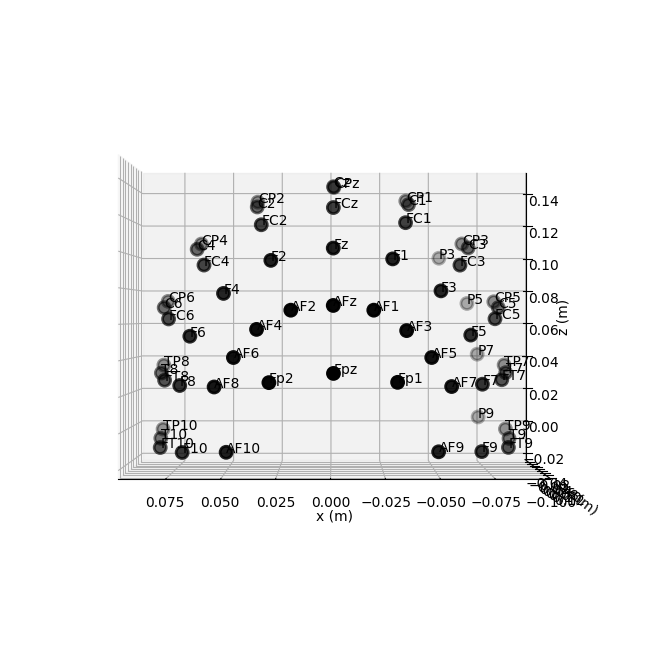

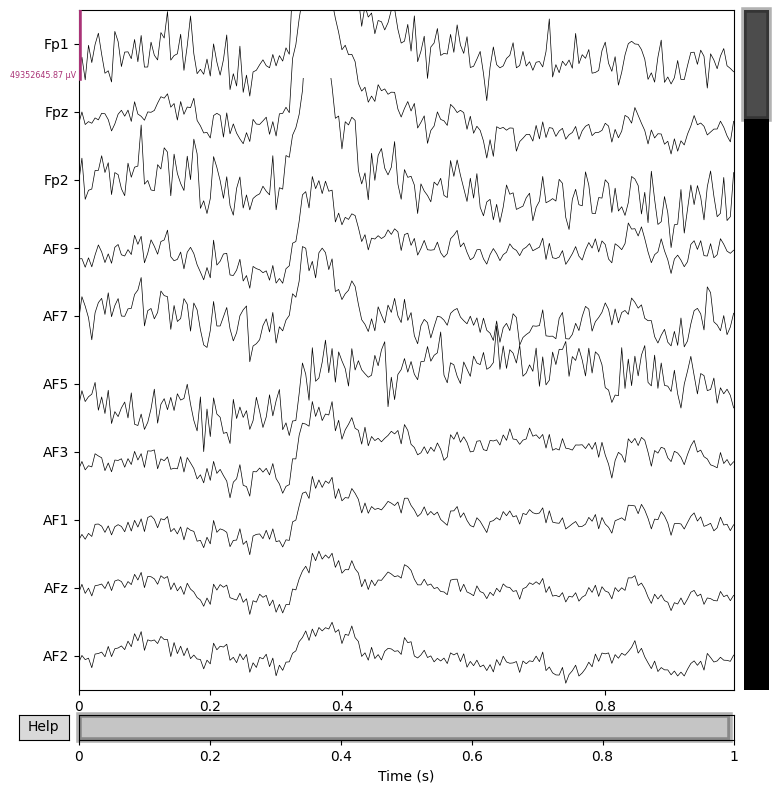

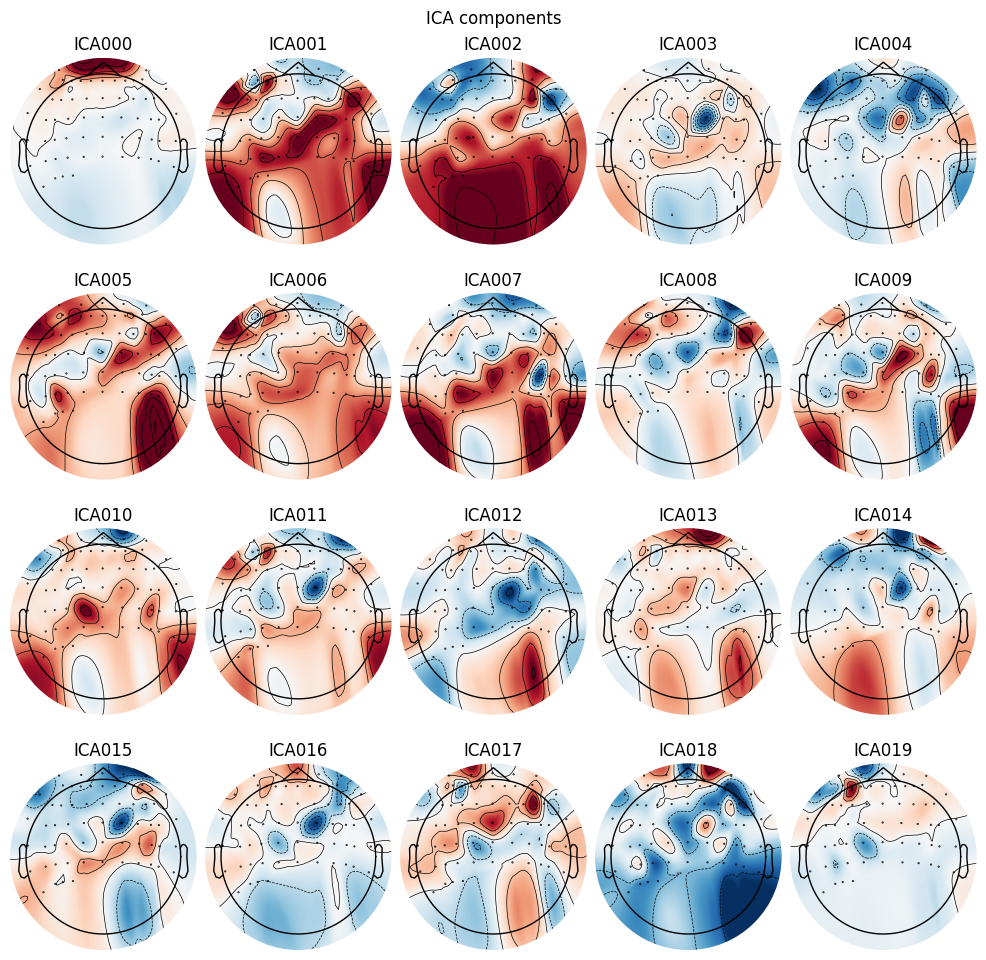

RuntimeError: No EOG channel(s) found

In [15]:
import mne
import numpy as np
from torcheeg.datasets import SEEDDataset
import matplotlib.pyplot as plt

# Load the cached TorchEEG dataset
dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=4
)

# Get the first sample
eeg_data, label = dataset[0]

# Create MNE info object
sfreq = 200  # Sampling frequency (200 Hz as per preprocessing)
ch_names = [f'Ch{i+1}' for i in range(eeg_data.shape[0])]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))

# Create MNE Raw object
raw = mne.io.RawArray(eeg_data, info)

# Use the 10-10 system montage
montage = mne.channels.make_standard_montage('standard_1005')

# Rename channels to match the montage
mapping = {f'Ch{i+1}': montage.ch_names[i] for i in range(len(ch_names))}
raw.rename_channels(mapping)

# Set the montage to the raw data
raw.set_montage(montage)

# Plot the sensor positions to verify the montage
raw.plot_sensors(kind='3d', show_names=True)

# Plot the raw EEG data before ICA
raw.plot(title='Raw EEG Data', n_channels=10, scalings='auto')

# Apply ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter=10000, method='infomax')
ica.fit(raw)

# Plot the ICA components to identify artifacts
ica.plot_components()

# Automatically detect eye blink artifacts
eog_indices, scores = ica.find_bads_eog(raw)
print(f"EOG (blink) artifact components: {eog_indices}")

# Exclude the identified artifact components
ica.exclude = eog_indices

# Apply ICA to remove the artifacts
raw_cleaned = raw.copy()
ica.apply(raw_cleaned)

# Plot the cleaned EEG data after ICA
raw_cleaned.plot(title='Cleaned EEG Data', n_channels=10, scalings='auto')

# Optional: Save the cleaned EEG data
raw_cleaned.save('cleaned_eeg_raw.fif', overwrite=True)


[2024-12-08 12:03:59] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


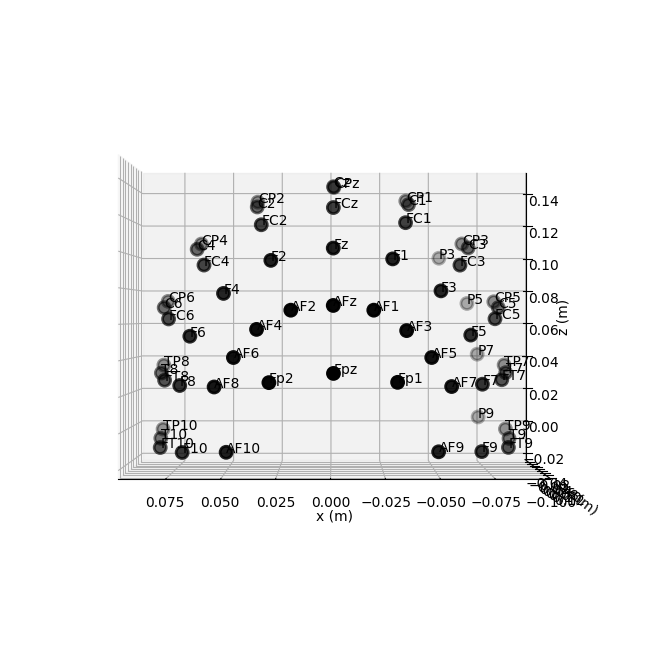

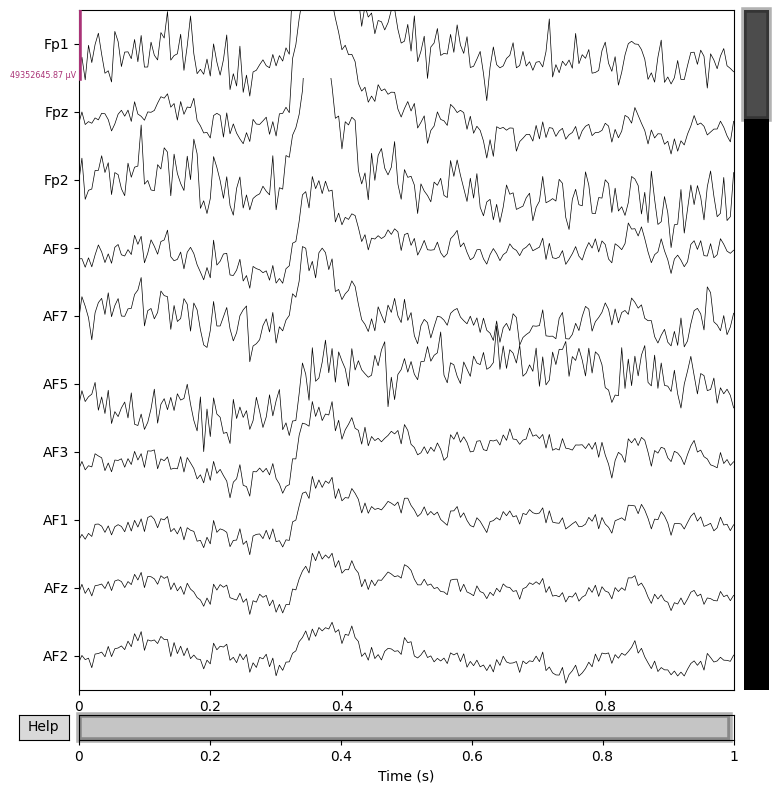

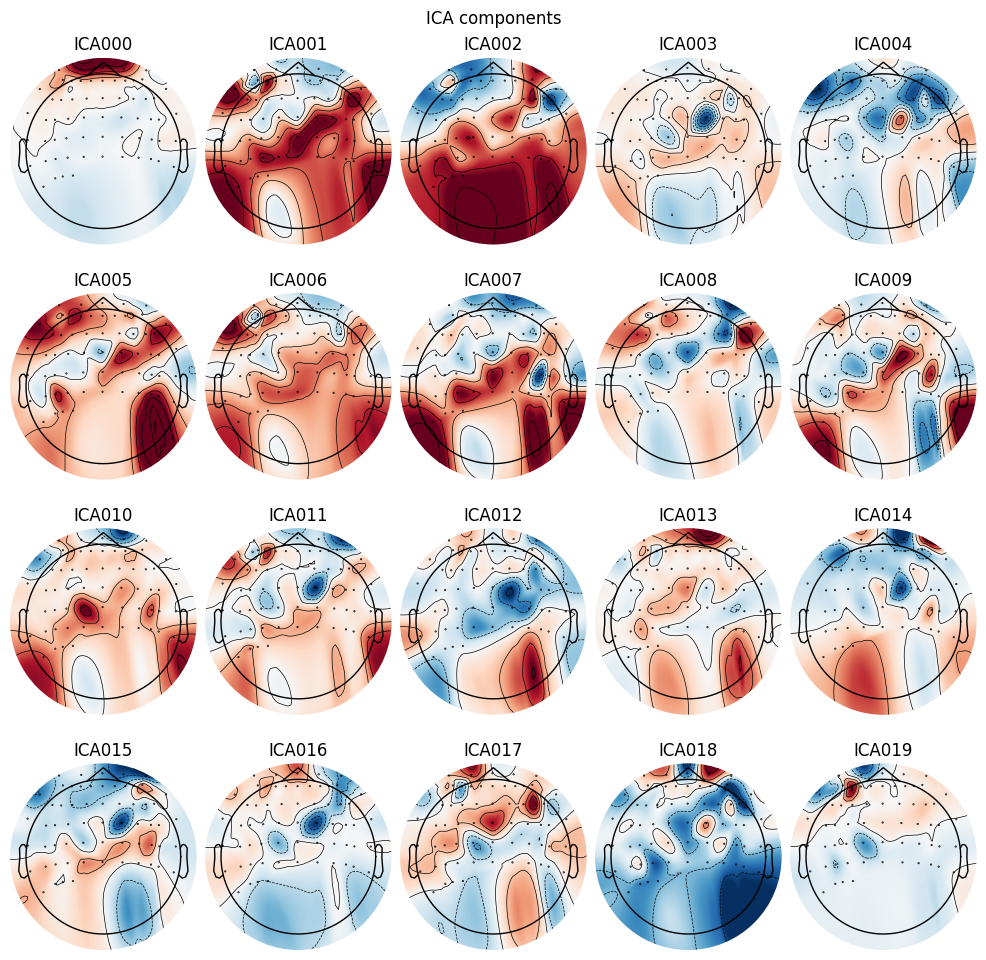

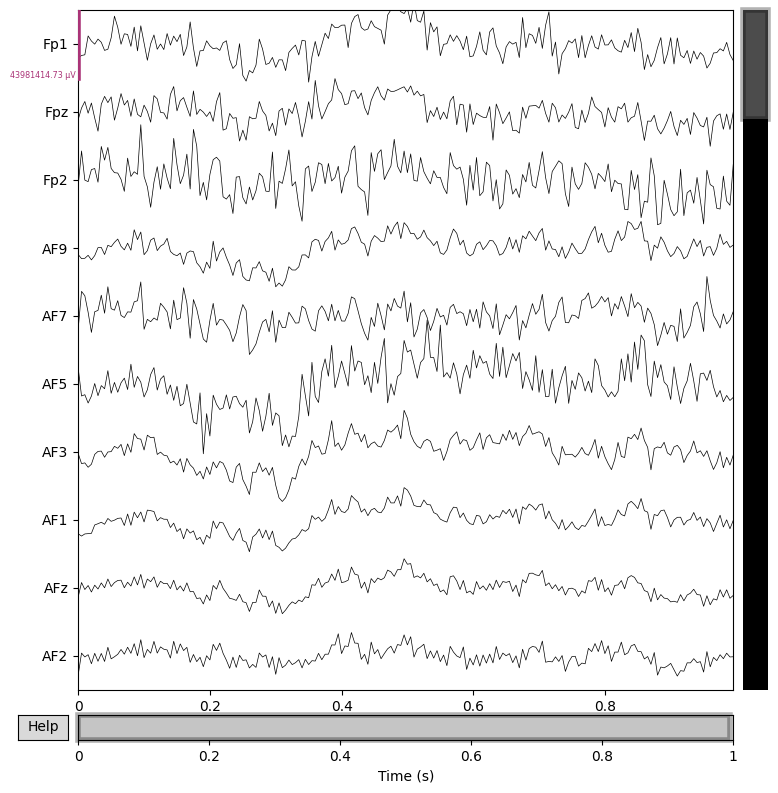

In [16]:
import mne
import numpy as np
from torcheeg.datasets import SEEDDataset
import matplotlib.pyplot as plt

# Load the cached TorchEEG dataset
dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=4
)

# Get the first sample
eeg_data, label = dataset[0]

# Create MNE info object
sfreq = 200  # Sampling frequency (200 Hz as per preprocessing)
ch_names = [f'Ch{i+1}' for i in range(eeg_data.shape[0])]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))

# Create MNE Raw object
raw = mne.io.RawArray(eeg_data, info)

# Use the 10-10 system montage
montage = mne.channels.make_standard_montage('standard_1005')

# Rename channels to match the montage
mapping = {f'Ch{i+1}': montage.ch_names[i] for i in range(len(ch_names))}
raw.rename_channels(mapping)

# Set the montage to the raw data
raw.set_montage(montage)

# Plot the sensor positions to verify the montage
raw.plot_sensors(kind='3d', show_names=True)

# Plot the raw EEG data before ICA
raw.plot(title='Raw EEG Data', n_channels=10, scalings='auto')

# Apply ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter=10000, method='infomax')
ica.fit(raw)

# Plot the ICA components to identify artifacts manually
ica.plot_components()

# Manually exclude components (e.g., based on visual inspection)
ica.exclude = [0, 1]  # Replace with the indices of identified artifact components

# Apply ICA to remove the artifacts
raw_cleaned = raw.copy()
ica.apply(raw_cleaned)

# Plot the cleaned EEG data after ICA
raw_cleaned.plot(title='Cleaned EEG Data', n_channels=10, scalings='auto')

# Optional: Save the cleaned EEG data
raw_cleaned.save('cleaned_eeg_raw.fif', overwrite=True)


In [17]:
ica.exclude = [0, 2, 7, 18]
ica.apply(raw_cleaned)


<RawArray | 62 x 200 (1.0 s), ~171 kB, data loaded>

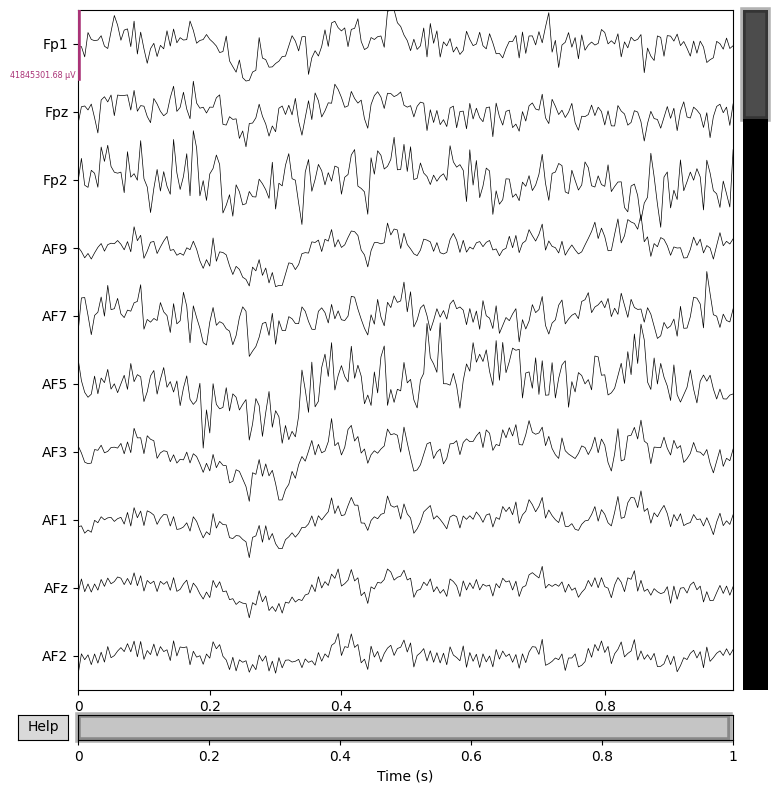

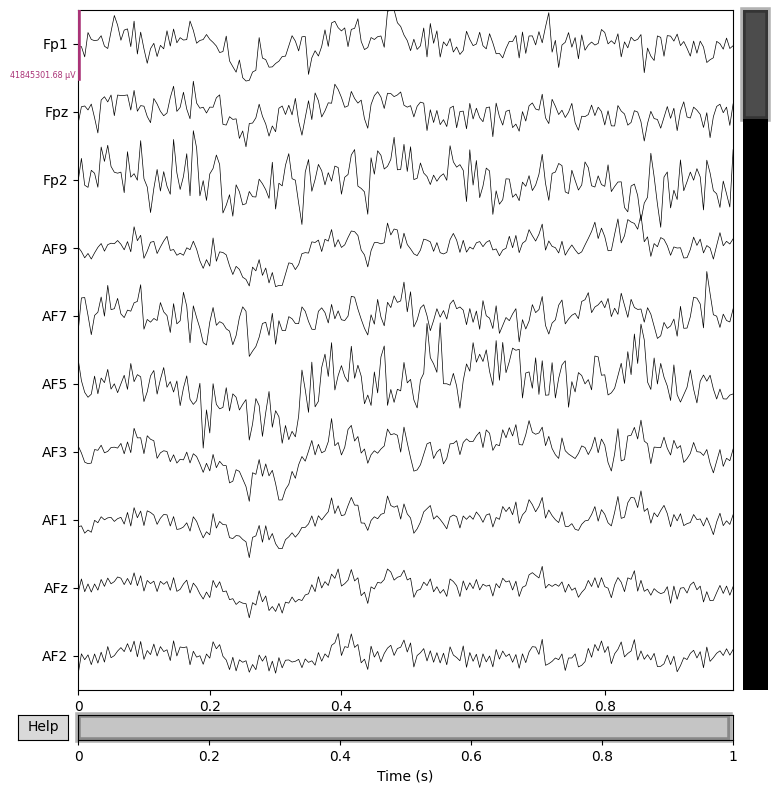

In [18]:
raw_cleaned.plot(title='Cleaned EEG Data', n_channels=10, scalings='auto')


In [19]:
raw_cleaned.save('cleaned_eeg_raw.fif', overwrite=True)


Applying it (ica) to the dataset

In [21]:
import os
import glob

# Path to the directory with the saved files
save_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data'

# Delete all .fif files in the directory
for file in glob.glob(os.path.join(save_dir, '*.fif')):
    os.remove(file)

print("Deleted all previously saved .fif files.")


Deleted all previously saved .fif files.


grouping by record instead

In [22]:
import mne
import numpy as np
from torcheeg.datasets import SEEDDataset
import os
from collections import defaultdict

# Load the complete dataset
dataset = SEEDDataset(
    io_path='C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,
    label_transform=None,
    num_worker=4
)

# Directory to save the cleaned data
save_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data'
os.makedirs(save_dir, exist_ok=True)

# Group samples by record_id
record_groups = defaultdict(list)

for idx in range(len(dataset)):
    eeg_data, label = dataset[idx]
    record_id = label['_record_id']
    record_groups[record_id].append(eeg_data)

# Process each unique record
for record_id, eeg_samples in record_groups.items():
    # Concatenate all samples within the record along the time axis
    eeg_data = np.hstack(eeg_samples)  # Shape: (channels, combined_time_points)
    
    # Create MNE info object
    sfreq = 200  # Sampling frequency (200 Hz)
    ch_names = [f'Ch{i+1}' for i in range(eeg_data.shape[0])]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))

    # Create MNE Raw object
    raw = mne.io.RawArray(eeg_data, info)
    
    # Assign a standard montage
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.rename_channels({f'Ch{i+1}': montage.ch_names[i] for i in range(len(ch_names))})
    raw.set_montage(montage)

    # Apply ICA
    ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter=10000, method='infomax')
    ica.fit(raw)
    
    # Manually exclude identified artifacts
    ica.exclude = [0, 2, 7, 18]
    ica.apply(raw)
    
    # Save the cleaned data
    save_path = os.path.join(save_dir, f'cleaned_{record_id}.fif')
    raw.save(save_path, overwrite=True)
    print(f"Processed and saved record {record_id}")


[2024-12-08 12:16:28] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Processed and saved record _record_0
Processed and saved record _record_1
Processed and saved record _record_2
Processed and saved record _record_3
Processed and saved record _record_4
Processed and saved record _record_5
Processed and saved record _record_6
Processed and saved record _record_7
Processed and saved record _record_8
Processed and saved record _record_9
Processed and saved record _record_10
Processed and saved record _record_11
Processed and saved record _record_12
Processed and saved record _record_13
Processed and saved record _record_14
Processed and saved record _record_15
Processed and saved record _record_16
Processed and saved record _record_17
Processed and saved record _record_18
Processed and saved record _record_19
Processed and saved record _record_20
Processed and saved record _record_21
Processed and saved record _record_22
Processed and saved record _record_23
Processed and saved record _record_24
Processed and saved record _record_25
Processed and saved re

checking quality

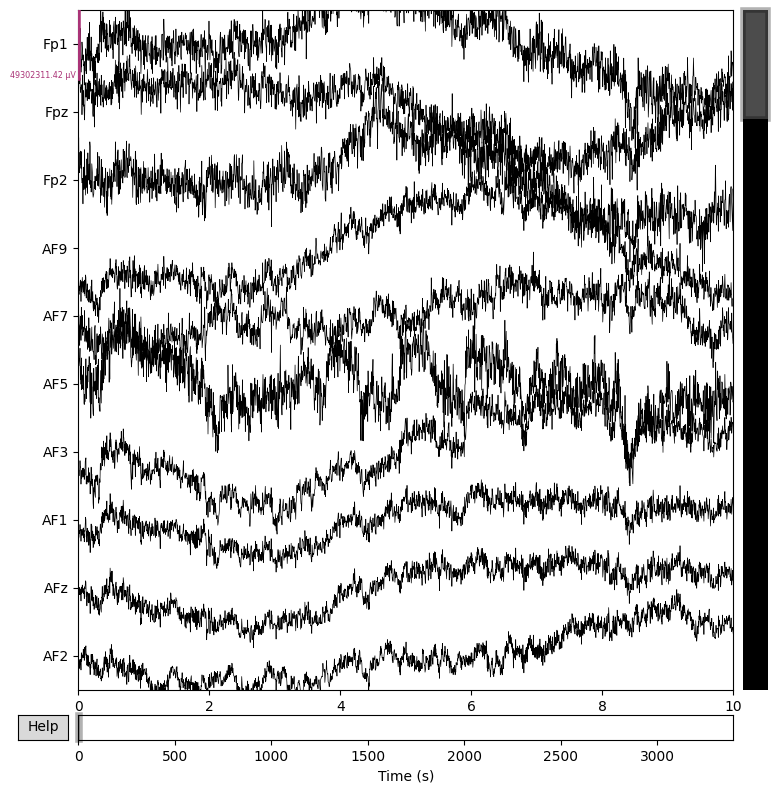

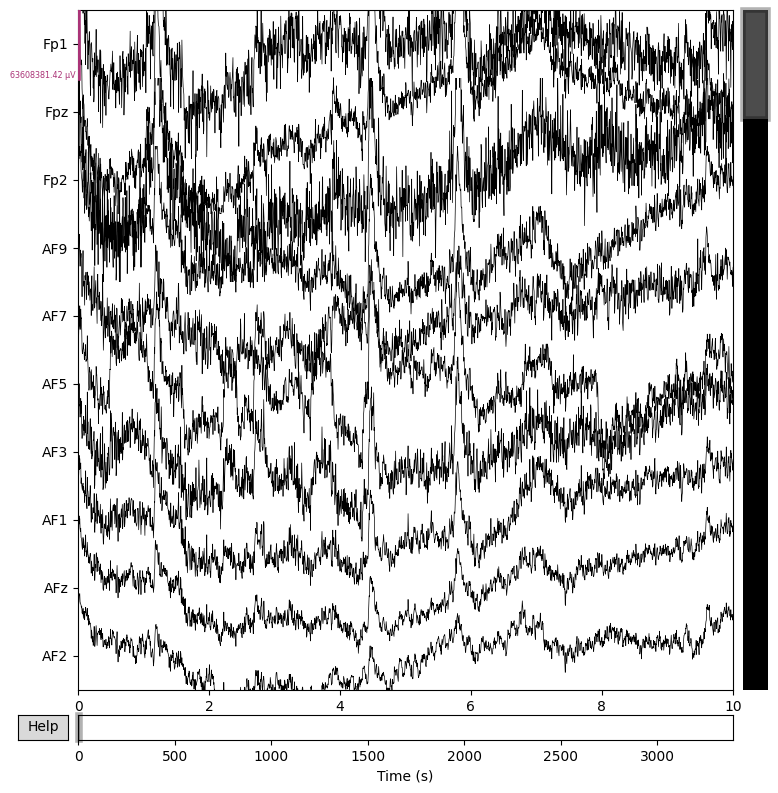

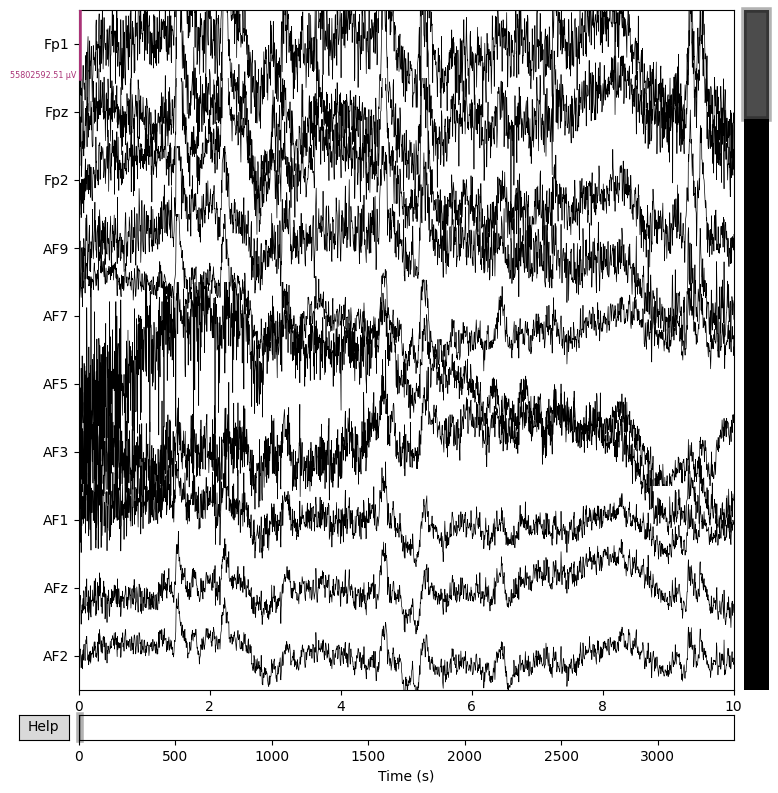

In [24]:
import mne
import os

cleaned_dir = 'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data'

for idx in range(3):  # Check the first 3 records as a sample
    file_path = os.path.join(cleaned_dir, f'cleaned__record_{idx}.fif')
    raw = mne.io.read_raw_fif(file_path, preload=True)
    raw.plot(title=f'Cleaned Record {idx}', n_channels=10, scalings='auto')


exporting to .mat

In [23]:
from scipy.io import savemat

for record_id in range(45):
    raw = mne.io.read_raw_fif(f'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data/cleaned__record_{record_id}.fif', preload=True)
    data = raw.get_data()
    savemat(f'C:/Users/tahir/Documents/EEg-based-Emotion-Recognition/cleaned_data/cleaned_{record_id}.mat', {'EEG': data})
    print(f'Exported record {record_id} to .mat')


Exported record 0 to .mat
Exported record 1 to .mat
Exported record 2 to .mat
Exported record 3 to .mat
Exported record 4 to .mat
Exported record 5 to .mat
Exported record 6 to .mat
Exported record 7 to .mat
Exported record 8 to .mat
Exported record 9 to .mat
Exported record 10 to .mat
Exported record 11 to .mat
Exported record 12 to .mat
Exported record 13 to .mat
Exported record 14 to .mat
Exported record 15 to .mat
Exported record 16 to .mat
Exported record 17 to .mat
Exported record 18 to .mat
Exported record 19 to .mat
Exported record 20 to .mat
Exported record 21 to .mat
Exported record 22 to .mat
Exported record 23 to .mat
Exported record 24 to .mat
Exported record 25 to .mat
Exported record 26 to .mat
Exported record 27 to .mat
Exported record 28 to .mat
Exported record 29 to .mat
Exported record 30 to .mat
Exported record 31 to .mat
Exported record 32 to .mat
Exported record 33 to .mat
Exported record 34 to .mat
Exported record 35 to .mat
Exported record 36 to .mat
Exported re